In [2]:
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git "pillow<7" ttach

In [1]:
!pip install torch --upgrade grad-cam

  Using cached torch-1.10.2-cp36-cp36m-manylinux1_x86_64.whl (881.9 MB)


In [2]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

import scipy
import os
import torch
import random
import json
import datetime
import time

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm 

tqdm.pandas()

In [3]:
skills = pd.read_csv("../Data/skills_one-hot.csv").set_index("candidate_id")
skills.head()

,skill_1,skill_2,skill_3,skill_5,skill_6,skill_7,skill_8,skill_9,skill_12,skill_13,...,skill_3926,skill_3927,skill_3928,skill_3929,skill_3930,skill_3931,skill_3932,skill_3933,skill_3934,skill_3935
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
skills = dict(zip(skills.index, skills.values))

In [5]:
certs = pd.read_csv("../Data/candidate_certificates_one-hot.csv").set_index("candidate_id")
certs.head()

,1,10,11,12,13,14,15,16,17,18,...,W4,W5,W7,W9,WB,WC,WD,WE,WF,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
certs = dict(zip(certs.index, certs.values))

In [7]:
licenses = pd.read_csv("../Data/licenses_one-hot.csv").set_index("candidate_id")
licenses.head()

,A,B,BE,C,CE,D,DE,G
candidate_id,,,,,,,,
84556,0,1,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,1
84731,1,1,0,0,0,0,0,0
85437,0,1,0,0,0,0,0,0
85627,0,1,1,0,0,0,0,0


In [8]:
licenses = dict(zip(licenses.index, licenses.values))

In [9]:
languages = pd.read_csv("../Data/languages_one-hot.csv").set_index("candidate_id")
languages.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84432,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
languages = dict(zip(languages.index, languages.values))

In [11]:
addresses = pd.read_csv("../Data/addresses_one-hot.csv").set_index("candidate_id")
addresses.head()

,0
candidate_id,
84556,91
84612,49
84731,3773
85437,3819
85627,1560


In [12]:
addresses = dict(zip(addresses.index, addresses.values))

In [13]:
w2v = json.load(open("../Data/embeddings.json"))
# Convert to ints
w2v = {int(k):{int(k2):v2 for k2, v2 in v.items()} for k, v in w2v.items()}

In [14]:
df_pred = pd.read_csv("../Data/df_pred_ext.csv").drop("Unnamed: 0", axis=1)

In [15]:
df_pred = df_pred.drop(["time_between", "job_order", "source"], axis=1)

In [16]:
# df_pred["time_between"] = (df_pred["time_between"] - df_pred["time_between"].mean()) / df_pred["time_between"].std()
df_pred["time_spent"] = (df_pred["time_spent"] - df_pred["time_spent"].mean()) / df_pred["time_spent"].std()
df_pred["c"] = df_pred["candidate_id"]

In [17]:
# GRAD-cam requires a single input into forward(), so we need to include candidate in there as well
df_pred = df_pred[["candidate_id", "c", "time_spent", "isco_functie_niveau", "education", "company_name", "function_id", "isco_code4"]]

In [18]:
df_pred.head()

,candidate_id,c,time_spent,isco_functie_niveau,education,company_name,function_id,isco_code4
0,84556,84556,-0.210459,2.0,0.0,324258,936,208
1,84556,84556,-0.252626,1.0,0.0,324258,809,348
2,84556,84556,-0.085012,2.0,0.0,329244,936,208
3,84556,84556,-0.370694,1.0,0.0,368140,1519,344
4,84556,84556,-0.363314,1.0,0.0,419826,1519,344


In [19]:
majority_class = df_pred["isco_code4"].mode().values[0]

In [20]:
features = df_pred.columns[1:]

In [21]:
career_paths = df_pred.groupby("candidate_id")

In [22]:
candidate_lens = career_paths.apply(lambda x: len(x) - 1).to_dict()

In [23]:
num_classes = len(df_pred["isco_code4"].unique())
num_features = len(career_paths.mean().columns)
num_classes, num_features

(355, 7)

In [24]:
maximum_career_duration = 25

In [25]:
# Convert to 2d-arrays, grabbing the last 25 jobs of each candidate and getting rid of candidate_ids as values
career_paths = career_paths.progress_apply(lambda x: x.values[-(maximum_career_duration + 1):,1:])

100%|██████████| 469568/469568 [00:49<00:00, 9541.02it/s]


In [26]:
# Drop careers that are only 1 job long
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens > 1)]

In [27]:
career_paths = career_paths.loc[career_paths.apply(lambda x: x[-1][-1] != x[-2][-1])]

In [28]:
career_paths.head()

candidate_id
84556    [[84556.0, -0.21045870102048395, 2.0, 0.0, 324...
84612    [[84612.0, -0.3685852264755267, 1.0, 0.0, 2017...
84731    [[84731.0, -0.35066422025728855, 1.0, 0.0, 353...
85437    [[85437.0, 0.3313881928721292, 1.0, 2.0, 5500....
85888    [[85888.0, -0.2895219637480053, 2.0, 3.0, 4233...
dtype: object

In [29]:
idxs = []
x = []
y = []

# max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, -1]
    
    if not np.isnan(label):       
        idxs.append(idx)
        x.append(career[:-1].reshape(len(career) - 1, num_features))
        y.append(label)

idxs = np.array(idxs)
x = np.array(x)
y = np.array(y)

In [30]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

In [31]:
max_len = len(max(x, key = lambda x: len(x)))
max_len

25

In [32]:
del df_pred
del x
del career_paths

In [33]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [34]:
len(to_fill), len(y)

(113724, 113724)

In [35]:
# to_fill = to_fill[:25000]
# y = y[:25000]

In [36]:
def create_loaders(to_fill, idxs, y, split_size=0.8, weight_type=3, batch_size=512):

    # Train test split
    split = split_size

    training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
    test = np.array(list(set(range(len(to_fill))) - set(training)))
    test, validation = test[:(len(test) // 2)], test[(len(test) // 2):]

    train_indices, val_indices, test_indices = idxs[training], idxs[validation], idxs[test]
    X_train, X_val, X_test = to_fill[training], to_fill[validation], to_fill[test]
    y_train, y_val, y_test = y[training].astype(int), y[validation].astype(int), y[test].astype(int)

    # Class weights
    counts = (np.bincount(y_train) + 1)
    
    if weight_type == 1:
        labels_weights = 1. / counts
    elif weight_type == 2:
        labels_weights = 1. / np.sqrt(counts)
    elif weight_type == 3:
        labels_weights = 2. / (0.5 * np.sqrt(counts))
    else:
        return NotImplemented
        
    weights = labels_weights[y_train]
    sampler = WeightedRandomSampler(weights, len(weights))

    # Create dataloaders
    train_data = TensorDataset(torch.Tensor(train_indices), 
                               torch.Tensor(X_train), 
                               torch.Tensor(y_train).type(torch.LongTensor))

    trainloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)

    val_data = TensorDataset(torch.Tensor(val_indices),
                             torch.Tensor(X_val),
                             torch.Tensor(y_val).type(torch.LongTensor))

    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    test_data = TensorDataset(torch.Tensor(test_indices),
                             torch.Tensor(X_test),
                             torch.Tensor(y_test).type(torch.LongTensor))

    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    
    return trainloader, valloader, testloader

In [37]:
class XCM(nn.Module):

    def __init__(self, num_classes, input_size, skills, certs, licenses, 
                 languages, addresses, w2v, candidate_lengths, max_len, 
                 F1=64, F2=16, window_size=0.2, skill_embedding_size=50, 
                 certs_embedding_size=20, license_embedding_size=3, 
                 language_embedding_size=10, address_embedding_size=25, 
                 function_embedding_size=50, isco4_embedding_size=25, 
                 education_embedding_size=3, isco_level_embedding_size=3, 
                 company_embedding_size=50, w2v_embedding_size=300):
        
        super(XCM, self).__init__()
              
        self.num_classes = num_classes
        self.input_size = input_size + w2v_embedding_size
        
        # Static embeddings: skills, certificates, licenses, languages
        self.skill_embedding = nn.Linear(317, skill_embedding_size, bias=False)
        self.skill_embedding.weight.data = torch.randn_like(self.skill_embedding.weight) 
        self.skill_embedding_size = skill_embedding_size
        
        self.certs_embedding = nn.Linear(98, certs_embedding_size, bias=False)
        self.certs_embedding.weight.data = torch.randn_like(self.certs_embedding.weight) 
        self.certs_embedding_size = certs_embedding_size
        
        self.license_embedding = nn.Linear(8, license_embedding_size, bias=False)
        self.license_embedding.weight.data = torch.randn_like(self.license_embedding.weight) 
        self.license_embedding_size = license_embedding_size
        
        self.language_embedding = nn.Linear(23, language_embedding_size, bias=False)
        self.language_embedding.weight.data = torch.randn_like(self.language_embedding.weight) 
        self.language_embedding_size = language_embedding_size 

        self.w2v_embedding_size = w2v_embedding_size
        
        # Address embedding
        self.address_embedding = nn.Embedding(4768, address_embedding_size)       
        self.address_embedding_size = address_embedding_size
        
        # Categorical feature embeddings
        self.function_embedding = nn.Embedding(2992, function_embedding_size)
        self.isco_code_embedding = nn.Embedding(num_classes, isco4_embedding_size)
        self.company_embedding = nn.Embedding(441153, company_embedding_size)
        self.education_embedding = nn.Embedding(6, education_embedding_size)
        self.isco_level_embedding = nn.Embedding(5, isco_level_embedding_size)
        
        self.function_embedding_size = function_embedding_size
        self.isco_code_embedding_size = isco4_embedding_size
        self.company_embedding_size = company_embedding_size
        self.education_embedding_size = education_embedding_size
        self.isco_level_embedding_size = isco_level_embedding_size
                
        # -6 --> embedded features get replaced
        N = self.input_size - 6 + skill_embedding_size + certs_embedding_size + \
            license_embedding_size + language_embedding_size + address_embedding_size + \
            function_embedding_size + isco4_embedding_size + company_embedding_size + \
            education_embedding_size + isco_level_embedding_size
        
        # Actual model
        window_size = int(max_len * window_size)
        D = N
        
        self.relu = nn.ReLU()
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        
        self.batchnorm = nn.BatchNorm2d(F1)  
        self.batchnorm2 = nn.BatchNorm2d(F2)
        
        self.conv2d_padding = nn.ZeroPad2d((0, 0, window_size // 2, (window_size - 1 ) // 2))
        
        self.conv2d = nn.Conv2d(in_channels=1,
                                out_channels=F1,
                                kernel_size=(window_size, 1),
                                stride=(1, 1))
        
        self._1x1 = nn.Conv2d(in_channels=F1, 
                              out_channels=1, 
                              kernel_size=(1, 1), # Maybe (100, 1, 1)?
                              stride=1)

        # Asymmetric padding to have a consistent shape for even and uneven window_sizes
        self.conv1d_padding = nn.ZeroPad2d((0, 0, window_size // 2, (window_size - 1 ) // 2))

        self.conv1d = nn.Conv1d(in_channels=1,
                                out_channels=F1, 
                                kernel_size=(window_size, D),
                                stride=1)
                
        self._1x1_2 = nn.Conv1d(in_channels=F1, 
                                out_channels=1, 
                                kernel_size=(1, 1),
                                stride=1)
        
        self.final_padding = nn.ZeroPad2d(((D + 1) // 2, D // 2, window_size // 2, (window_size - 1 ) // 2))
            
        self.final_conv1d = nn.Conv1d(in_channels=1,
                                      out_channels=F2, 
                                      kernel_size=(window_size, D + 1),
                                      stride=1)
        
        self.avgpool2d = nn.AvgPool3d(kernel_size=(F2, 1, 1),
                                      stride=1)
        
        self.fc = nn.Linear(max_len * (D + 1), num_classes)
                    
        self.softmax = nn.Softmax(dim=-1)
        
        # Skill lookup
        self.skills = skills
        
        # Certificate lookup
        self.certs = certs
        
        # License lookup
        self.licenses = licenses
        
        # Language lookup
        self.langs = languages
        
        # Address lookup
        self.adds = addresses
        
        # w2v lookup
        self.w2v_keys = set(w2v.keys())
        self.w2v = w2v
        
        # Career durations
        self.candidate_lengths = candidate_lengths
        self.max_len = max_len      
        
        def get_from_dict(x, cdict, N):
            return cdict.get(x, np.zeros((N,)))

        self.retrieve_static = np.vectorize(get_from_dict, otypes=[np.ndarray])   
                
    
    def w2v_lookup(self, candidate, career_duration):
        """Finds a candidate's CVs and converts them to a tensor of length career_duration"""
            
        actual_career_duration = career_duration
        career_duration = min(career_duration, max_len)
            
        # Look for cvs
        if candidate.item() in self.w2v_keys:
            cvs = self.w2v[candidate.item()]
                
            storage = []

             # If a candidate only has one CV, proceed as normal
            if len(cvs.keys()) == 1:
                w2v_list = torch.Tensor(cvs[0]).to(device)
                w2v_list = torch.stack([w2v_list] * career_duration).to(device)
            else: # Otherwise, stack them accordingly
                ks = np.array(list(cvs.keys()))
                
                to_skip = 0
                                
                # Make sure to use candidates' most recent max_len cvs
                if actual_career_duration > self.max_len:                                        
                    # Update to only include most recent max_len
                    ks -= max_len
                    
                    # Drop everything older than max_len time steps
                    ks_2 = np.array([ks[i] for i in range(len(ks)) if i < len(ks) and (i + 1 >= len(ks) or ks[i + 1] > 0)])
                    
                    # Store how many we need to skip while indexing
                    to_skip = len(ks) - len(ks_2)
                    
                    # Update ks
                    ks = ks_2
                    ks[0] = 0
                    
                # Due to clipping, some careers are longer than max_len
                ks = np.array([k for k in ks if k <= min(self.max_len, career_duration)])

                # Find how many time steps (rows) each CV lasted
                durations = [ks[i+1] - ks[i]
                             if i < (len(ks) - 1) 
                             else career_duration - ks[i]
                             for i in range(len(ks))]

                embed_values = list(cvs.values())

                # When the CV got updated on the last timestep, aka our test value
                # Remove it from the list of durations, as it should be ignored
                if durations[-1] == 0: 
                    durations.pop()

                # Create Tensor(s)
                if durations:
                    for i, duration in enumerate(durations):
                        # Figure out negative duration cause
                        storage.append(torch.stack([torch.Tensor(embed_values[i + to_skip]).to(device)] * duration, dim=0))
                else:
                    storage.append(torch.Tensor(cvs[0]))

                # Combine stored tensors into a single tensor
                w2v_list = torch.cat((storage)).type(torch.LongTensor).to(device)
        else:
            w2v_list = torch.LongTensor([0] * self.w2v_embedding_size).to(device)
            w2v_list = torch.stack([w2v_list] * career_duration)

        return w2v_list
    
    def create_tensor(self, x):
        # Default width of a row (filled with 0s)
        feature_width = torch.Tensor([0] * (self.skill_embedding_size + self.certs_embedding_size
                                            + self.license_embedding_size + self.language_embedding_size
                                            + self.address_embedding_size + self.w2v_embedding_size)).type(torch.LongTensor).to(device)
        
        candidate_features = []
        
        # Extract candidate_ids
        candidate = x[:,:,0][:,-1].cpu()
        
        # Everything else stays in x
        x = x[:,:,1:]
        
        skill_list = self.retrieve_static(candidate, self.skills, 317)
        skill_list = torch.LongTensor(np.stack(skill_list)).to(device)
        
        certs_list = self.retrieve_static(candidate, self.certs, 98)
        certs_list = torch.LongTensor(np.stack(certs_list)).to(device)
        
        license_list = self.retrieve_static(candidate, self.licenses, 8)
        license_list = torch.LongTensor(np.stack(license_list)).to(device)
        
        langs_list = self.retrieve_static(candidate, self.langs, 23)
        langs_list = torch.LongTensor(np.stack(langs_list)).to(device)
            
        address = self.retrieve_static(candidate, self.adds, 1)
        address = torch.LongTensor(np.stack(address)).to(device)
        
        # Embed every static feature
        skill_list, certs_list, license_list, langs_list = [self.skill_embedding(skill_list.type(torch.FloatTensor).to(device)),
                                                            self.certs_embedding(certs_list.type(torch.FloatTensor).to(device)),
                                                            self.license_embedding(license_list.type(torch.FloatTensor).to(device)),
                                                            self.language_embedding(langs_list.type(torch.FloatTensor).to(device))]
                
        # Combine and embed
        batch_features = torch.cat([skill_list, certs_list, 
                                    license_list, langs_list], dim=-1).type(torch.FloatTensor).to(device)
            
        batch_addresses = self.address_embedding(address)[:,0,:]
        
        durations = []
        
        # For each candidate in the current batch
        for i, c in enumerate(candidate):
            # Get career duration
            career_duration = self.candidate_lengths[c.item()]
            
            # Get CV embeddings
            w2v_list = self.w2v_lookup(c, career_duration)
                                    
            # Reset to max_len
            career_duration = min(career_duration, max_len)
            durations.append(career_duration)

            # Only create zeros if needed (e.g. less than max_len career duration)
            if (self.max_len - career_duration) > 0:
                zeros = torch.stack([feature_width] * (self.max_len - career_duration))                
            else: # Reset zeros to prevent shape mismatch
                zeros = torch.LongTensor([]).to(device)
                        
            # Broadcast and add static features
            static_features = torch.stack([batch_features[i]] * career_duration).type(torch.LongTensor).to(device)
            address_emb = torch.stack([batch_addresses[i]] * career_duration).type(torch.LongTensor).to(device)
            
            # Combine w2v, static features, and address
            full_features = torch.cat([w2v_list, static_features, address_emb], dim=1)
                                    
            # Broadcast CV, static, and address to the correct length
            full_features = torch.cat([zeros, full_features], dim=0)
                    
            # Store result
            candidate_features.append(full_features)
                                
         # Convert list of tensors to actual tensor
        additional_features = torch.stack((candidate_features)).type(torch.FloatTensor).to(device)
                
        # isco_functie_niveau, education, function_id, isco_code4
        isco_level, education, company_name, function_id, isco_code = [x[:,:,-5],
                                                                       x[:,:,-4],
                                                                       x[:,:,-3],
                                                                       x[:,:,-2],
                                                                       x[:,:,-1]]
        
        x = x[:,:,:-5].to(device)
        
        isco_level_smoothing = (isco_level != 0).unsqueeze(-1)
        education_smoothing = (education != 0).unsqueeze(-1)
        company_name_smoothing = (company_name != 0).unsqueeze(-1)
        function_id_smoothing = (function_id != 0).unsqueeze(-1)
        isco_code_smoothing = (isco_code != 0).unsqueeze(-1)
        
        isco_level, education, company_name, function_id, isco_code  = [self.isco_level_embedding(isco_level.type(torch.LongTensor).to(device)) * isco_level_smoothing,
                                                                        self.education_embedding(education.type(torch.LongTensor).to(device)) * education_smoothing,
                                                                        self.company_embedding(company_name.type(torch.LongTensor).to(device)) * company_name_smoothing,
                                                                        self.function_embedding(function_id.type(torch.LongTensor).to(device)) * function_id_smoothing,
                                                                        self.isco_code_embedding(isco_code.type(torch.LongTensor).to(device)) * isco_code_smoothing]   
                
        # Add features
        x = torch.cat([x, isco_level, education, company_name, function_id, isco_code, additional_features], dim=2)     
                                    
        return x, durations
 
    def forward(self, x):                       
        # Reshape to allow conv2D
        x = x.unsqueeze(-1)
        x = x.transpose(1, 3)
        x = x.transpose(2, 3)
                
        # Top part:
        x1 = self.conv2d_padding(x)
        x1 = self.conv2d(x1)
        x1 = self.batchnorm(x1)
        x1 = self.relu1(x1)
        x1 = self._1x1(x1)
        x1 = self.relu1(x1)
        # x1 = self.dropout(x1)

        # Bottom part: 
        x = self.conv1d_padding(x)
        x2 = self.conv1d(x)
        x2 = self.batchnorm(x2)
        x2 = self.relu2(x2)
        x2 = self._1x1_2(x2)
        x2 = self.relu2(x2)
        # x2 = self.dropout(x2)
        
        # Concatenate                
        x = torch.cat([x1, x2], dim=-1)
                
        # Conv 1D
        x = self.final_padding(x)
        x = self.final_conv1d(x)
        x = self.batchnorm2(x)
                                
        # Global average pooling
        x = self.avgpool2d(x)
        
        x = x.flatten(start_dim=1)
        
        # x = self.dropout(x)
                    
        x = self.fc(x)
                
        # softmax
        out = self.softmax(x)
        return x

In [38]:
def train_loop(model, trainloader, valloader, optimizer, scheduler, criterion, num_epochs):

    results = defaultdict(list)
    
    passed = [0]
    training_losses = [6]
    test_losses = [6]
    accuracy = [0]
    
    highest_performance = 0
    
    # Train the model
    for epoch in range(num_epochs):
        start = time.time()
        print("-------------------------------------------------------------------------------")
        print(f"Epoch starting at: {datetime.now().strftime('%H:%M:%S')}")
        
        training_loss = 0
        train_acc1 = 0
        
        for i, (candidate, career, job) in enumerate(trainloader):
            batch_start = time.time()
            
            candidate, career, job = candidate.to(device), career.to(device), job.to(device)
            optimizer.zero_grad()
            
            career, _ = model.create_tensor(career)
            outputs = model(career)
            
            train_acc1 += (outputs.argmax(1) == job).type(torch.float).sum().item()
                                    
            # obtain the loss function
            loss = criterion(outputs, job)
            loss = loss.mean()       
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            
            batch_end = time.time()
            batch_duration = batch_end - batch_start
            epoch_duration = int(batch_duration * (len(trainloader) - i))
            print("Epoch: %d, batch: %d/%d, loss: %1.5f, Epoch ETA: %02d:%02d:%02d  " % (epoch + 1,
                                                                                         i + 1,
                                                                                         len(trainloader), 
                                                                                         loss.item(),
                                                                                         epoch_duration // 3600,
                                                                                         (epoch_duration % 3600) // 60,
                                                                                         (epoch_duration % 60)), end="\r")

        training_loss /= len(trainloader)
        train_acc1 /= len(trainloader.dataset)
                
        stats = test_loop(valloader, model, criterion)
        
        done = int(time.time() - start)        
        print(f"Epoch duration: {int((done) // 60)}:{int((done) % 60):02d}")
        
        results["Epoch"].append(epoch + 1)
        results["Acc@1"].append(stats[0])
        results["Acc@5"].append(stats[1])
        results["Acc@10"].append(stats[2])
        results["test_loss"].append(stats[3])
        results["Acc@1 (test)"].append(stats[4])
        results["Acc@5 (test)"].append(stats[5])
        results["Acc@10 (test)"].append(stats[6])
        results["test_loss (test)"].append(stats[7])
        results["training_loss"].append(training_loss)
        results["duration"].append(done)
        
        if stats[0] > highest_performance:
            torch.save(model.state_dict(), "../models/optimal_eCNN.pt")
            highest_performance = stats[0]

        scheduler.step()
                
        passed.append(epoch + 1)
        training_losses.append(training_loss)
        test_losses.append(stats[4])
        accuracy.append(stats[0])
        
        plt.plot(passed, training_losses, label="Training Loss")
        plt.plot(passed, test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.legend()
        plt.show()
                
    return results
        
def test_loop(dataloader, testloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, acc1, acc5, acc10, acc20 = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in dataloader:
            career, job = career.to(device), job.to(device)
            
            career, _ = model.create_tensor(career)
            pred = model(career)
            
            test_loss += criterion(pred, job).mean().item()
            acc1 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5 = []
            at10 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5.append(answer.item() in predictions[:5])
                at10.append(answer.item() in predictions[:10])
            
            acc5 += np.sum(at5)
            acc10 += np.sum(at10)
            
    test_loss /= num_batches
    acc1 /= size
    acc5 /= size
    acc10 /= size
    print(f"\nVal Error:")
    print(f"Acc@1: {(100*acc1):>0.2f}%, Acc@5: {100*acc5:>0.2f}%, " +\
          f"Acc@10: {100*acc10:>0.2f}% Avg loss: {test_loss:>8f}")
    
    size_2 = len(testloader.dataset)
    num_batches_2 = len(testloader)
    test_loss_2, acc1_2, acc5_2, acc10_2 = 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in testloader:
            career, job = career.to(device), job.to(device)
            pred, weight, _ = model(candidate, career)
            
            test_loss_2 += criterion(pred, job).mean().item()
            acc1_2 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5_2 = []
            at10_2 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5_2.append(answer.item() in predictions[:5])
                at10_2.append(answer.item() in predictions[:10])
            
            acc5_2 += np.sum(at5_2)
            acc10_2 += np.sum(at10_2)
            
    test_loss_2 /= num_batches_2
    acc1_2 /= size_2
    acc5_2 /= size_2
    acc10_2 /= size_2
    print(f"\nTest Error:")
    print(f"Acc@1: {(100*acc1_2):>0.2f}%, Acc@5: {100*acc5_2:>0.2f}%, " +\
          f"Acc@10: {100*acc10_2:>0.2f}%, Avg loss: {test_loss_2:>8f}")
    
    return acc1, acc5, acc10, acc20, acc1_2, acc5_2, acc10_2, test_loss

In [39]:
sns.set_style("white")

In [ ]:
num_epochs = 3
current = 0

criterion = torch.nn.CrossEntropyLoss()

full_results = []

learning_rates = [1e-3]
window_sizes = [0.4]
F1_sizes = [8]
F2_sizes = [64]

skill_embedding_size=100
certs_embedding_size=50
license_embedding_size=10
language_embedding_size=15
address_embedding_size=25
function_embedding_size=250
isco4_embedding_size=150
education_embedding_size=10
isco_level_embedding_size=10
company_embedding_size=250
w2v_embedding_size = 300

try:            
    for learning_rate in learning_rates:
        for F1 in F1_sizes:
            for F2 in F2_sizes:
                for window_size in window_sizes:

                    cnn = XCM(num_classes=num_classes,
                              input_size=num_features,
                              F1=F1,
                              F2=F2,
                              window_size=window_size,
                              skills=skills, 
                              certs=certs,
                              licenses=licenses,
                              languages=languages,
                              addresses=addresses,
                              w2v=w2v,
                              skill_embedding_size=skill_embedding_size,
                              address_embedding_size=address_embedding_size,
                              function_embedding_size=function_embedding_size,
                              isco4_embedding_size=isco4_embedding_size,
                              company_embedding_size=company_embedding_size,
                              candidate_lengths=candidate_lens,
                              w2v_embedding_size=w2v_embedding_size,
                              max_len=max_len)

                    cnn = cnn.to(device)

                    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
                    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
                                        
                    trainloader, valloader, testloader = create_loaders(to_fill, idxs, y, split_size=0.8, 
                                                                        weight_type=3, batch_size=128)

                    # Store results of current configuration
                    outcome = train_loop(cnn, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)
                    outcome["lr"] = [learning_rate] * num_epochs
                    outcome["F1 size"] = [F1] * num_epochs
                    outcome["F2 size"] = [F2] * num_epochs
                    outcome["Window size"] = [window_size] * num_epochs

                    full_results.append(outcome)

                    current += 1

except KeyboardInterrupt:
    pass

-------------------------------------------------------------------------------
Epoch starting at: 01:56:35


In [41]:
merge_results = defaultdict(list)

for res in full_results:
    for k, v in res.items():
        merge_results[k].extend(v)
        
total = pd.DataFrame(merge_results).set_index(["lr", "F1 size", "F2 size", "Window size", "Epoch"])

KeyError: "None of ['lr', 'F1 size', 'F2 size', 'Window size', 'Epoch'] are in the columns"

In [42]:
total.head()

NameError: name 'total' is not defined

In [43]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

skill_embedding_size = 15
certs_embedding_size = 20
license_embedding_size = 5
language_embedding_size = 5
address_embedding_size = 10
function_embedding_size = 40
isco4_embedding_size = 35
education_embedding_size = 5
isco_level_embedding_size = 5
company_embedding_size = 30
w2v_embedding_size = 30

cnn = XCM(num_classes=num_classes,
          input_size=num_features,
          F1=16,
          F2=256,
          window_size=0.8,
          skills=skills, 
          certs=certs,
          licenses=licenses,
          languages=languages,
          addresses=addresses,
          w2v=w2v,
          skill_embedding_size=skill_embedding_size,
          address_embedding_size=address_embedding_size,
          function_embedding_size=function_embedding_size,
          isco4_embedding_size=isco4_embedding_size,
          company_embedding_size=company_embedding_size,
          candidate_lengths=candidate_lens,
          w2v_embedding_size=w2v_embedding_size,
          max_len=max_len)

cnn.load_state_dict(torch.load("../models/eCNN_1.pt"))

<All keys matched successfully>

In [44]:
cnn.to(device)

XCM(
  (skill_embedding): Linear(in_features=317, out_features=15, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=20, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (w2v_embedding): Linear(in_features=300, out_features=30, bias=False)
  (address_embedding): Embedding(4768, 10)
  (function_embedding): Embedding(2992, 40)
  (isco_code_embedding): Embedding(355, 35)
  (company_embedding): Embedding(441153, 30)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 3)
  (relu): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(1, 16, kernel_size=(20, 1), stride=(1, 1), padding=same)
  (

In [44]:
trainloader, valloader = create_loaders(to_fill, idxs, y, split_size=0.8, 
                                        weight_type=3, batch_size=512)

Batch accuracy: 0.1484375

Majority class accuracy: 0.1484375
Majority class predictions: 0.03125


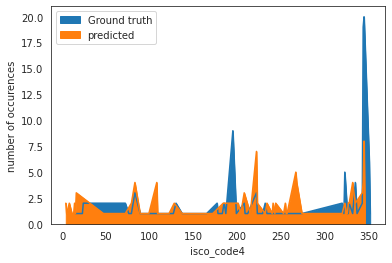

In [44]:
with torch.no_grad():
    for candidate, career, job in valloader:
        candidate, career, job = candidate.to(device), career.to(device), job.to(device)
        
        career, duration = cnn.create_tensor(career)
        pred = cnn(career)
        
        print("Batch accuracy:", (pred.argmax(1) == job).type(torch.float).mean().item())    
        print()

        a = pd.Series(Counter(job.tolist()))
        a.sort_index().plot(kind="area", label="Ground truth")
        
        b = pd.Series(Counter(pred.argmax(1).tolist()))
        b.sort_index().plot(kind="area", label="predicted")
        plt.xlabel("isco_code4")
        plt.ylabel("number of occurences")
        plt.legend()
        
        # Check how often the model predicted the previous job + compare to baseline performance
        print("Majority class accuracy:", (job == majority_class).cpu().numpy().mean())        
        print("Majority class predictions:", (pred.argmax(1) == majority_class).cpu().numpy().mean())
        
        plt.show()        
        break

In [47]:
del skills
del certs
del w2v
del languages
del to_fill

In [46]:
# x, isco_level, source, education, company_name, function_id, isco_code, w2v_list, skill_list, certs_list, license_list, langs_list, address_emb
feature_names = ["Time spent", "isco level", "education", "company name", "function", "isco code",
                 "cv", "skills", "certificates", "licenses", "languages", "location"]

# skill_embedding_size=50, certs_embedding_size=20,
# license_embedding_size=3, language_embedding_size=10,
# address_embedding_size=25, function_embedding_size=50, 
# isco4_embedding_size=25, education_embedding_size=3, 
# isco_level_embedding_size=3, company_embedding_size=50
source_embedding_size = 1
# w2v_embedding_size = 300

embedding_sizes= [0, 1, isco_level_embedding_size, education_embedding_size, company_embedding_size, 
                  function_embedding_size, isco4_embedding_size, w2v_embedding_size, skill_embedding_size, 
                  certs_embedding_size, license_embedding_size, language_embedding_size, address_embedding_size]

In [47]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [48]:
def merge_layers(output, embedding_sizes, axis="features"):
    """order: start=0, reg_features, isco_level_embedding_size, source_embedding_size, 
              education_embedding_size, company_embedding_size, function_embedding_size, 
              isco4_embedding_size, w2v_embedding_size, skill_embedding_size, 
              certs_embedding_size, license_embedding_size, language_embedding_size, 
              address_embedding_size"""
        
    if axis == "features":
        output = output.T
        idxs = np.cumsum(embedding_sizes)
        result = np.stack([output[idxs[i]:idxs[i+1]].mean(axis=0) for i in range(len(idxs) - 1)])
    elif axis == "time":
        result = output.sum(axis=1)
        # result = np.stack([result] * (len(embedding_sizes) - 1))
    else:
        return NotImplemented
        
    return result

In [49]:
def apply_gradcam(model, feature_layer, time_layer, valloader, full_batch=True, group=None, min_len=4, max_len=10):
    
    # model.softmax = Identity()

    # Initialize gradcam
    cam = GradCAM(model=model, target_layers=[feature_layer], use_cuda=True)
    cam2 = GradCAM(model=model, target_layers=[time_layer], use_cuda=True)
            
    if group == "Finance":
        allowed = {i - 1 for i in {5, 20, 70, 71, 72, 73, 74, 75, 142, 143, 146, 195}}
    elif group == "Healthcare":
        allowed = {i - 1 for i in{16, 17, 48, 49, 50, 51, 52, 53, 54, 55, 
                                  56, 57, 58, 59, 60, 127, 128, 129, 130,
                                  131, 132, 133, 134, 135, 136, 137, 138,
                                  140, 141, 128, 234, 235, 236}}
    elif group == "Customer_support":
        allowed = {i - 1 for i in {152, 183, 185, 186, 187, 188, 189, 190, 191, 192}}
    else:
        allowed = set(range(0, 355))
    
    
    while True:
        # Create batch
        c, i, jobs = next(iter(valloader))

        # Convert batch to tensor
        i, duration = cnn.create_tensor(i.to(device))

        for j in range(len(i)):
            if jobs[j].item() in allowed:
                curr = i[j]
                dur = duration[j]
                candidate = c[j]
                curr_class = jobs[j].item()

                if min_len < dur < max_len:
                    curr = curr.unsqueeze(0)

                    cam_result = cam(input_tensor=curr, targets=[ClassifierOutputTarget(curr_class)])[0]
                    cam_result2 = cam2(input_tensor=curr, targets=[ClassifierOutputTarget(curr_class)])[0]
                    values = merge_layers(curr[0].cpu().detach(), embedding_sizes)

                    # Values, gradcam on features, gradcam on time steps, career_duration
                    return values, cam_result, cam_result2, dur, candidate, curr_class

In [50]:
def visualize_gradients(model, feature_layer, time_layer, valloader, lang="en", group=None):
    
    if lang != "en":        
        feature_names = ["Dagen gewerkt", "Werkniveau", "Opleidingsniveau", "Bedrijf", "Functie", "Isco code",
                         "CV", "Vaardigheden", "Certificaten", "Rijbewijzen", "Talen", "Postcode"]
    
    good = False
    
    while not good:
        values, cam, cam2, career_duration, candidate, curr_class = apply_gradcam(model, feature_layer, time_layer, valloader, group=group)

        print(f"Current group: {group}\nCurren candidate: {int(candidate.item())}\nClass: {curr_class + 1}")

        to_plot = merge_layers(cam, embedding_sizes, axis="features")
        time = merge_layers(cam2, embedding_sizes, axis="time")

        to_plot = to_plot.T[-career_duration:].T
        time = time.T[-career_duration:].T

        values = merge_layers(values.T, embedding_sizes)

        # Sum each feature over the time dimension and normalize    
        feature_weight = to_plot.T.sum(axis=0)    

        feature_weight /= feature_weight.sum()

        # Normalized feature attention 
        series = pd.Series(feature_weight, index=feature_names).sort_values(ascending=False)    

        # Create grid
        fig = plt.figure(figsize=(12, 8))
        grid = plt.GridSpec(2, 2, wspace=0.35, hspace=0.5)
        grid.update(top=0.9)

        ax1 = plt.subplot(grid[0, 0])
        ax2 = plt.subplot(grid[0, 1])
        ax3 = plt.subplot(grid[1, :])
        # ax4 = plt.subplot(grid[2, :2])

        if lang == "en":
            fig.suptitle("Attention types")
        else:
            fig.suptitle("Soorten aandacht")

        # Plot total attention for each feature
        sns.barplot(x=series.values * 100, y=series.index, ax=ax1)
        # ax1.set_xticklabels(labels=series.values, rotation=90)
        if lang == "en":
            ax1.set_xlabel("Gradient")
            ax1.set_title("Attention per feature")
        else:
            ax1.set_xlabel("Aandacht")
            ax1.set_title("Aandacht per eigenschap")
            ax1.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
            ax1.grid(axis='x')
            ax1.set_axisbelow(True)

        series2 = pd.Series(dict(zip(range(1, career_duration + 1), time / time.sum())))

        sns.barplot(x=series2.index, y=series2.values  * 100, ax=ax2)
        if lang == "en":
            ax2.set_title("Attention per time step")
            ax2.set_ylabel("Attention score")
            ax2.set_xlabel("Time step")
        else:
            ax2.set_title("Aandacht per baan nummer")
            ax2.set_ylabel("Aandacht")
            ax2.set_xlabel("Baan nummer")
            ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
            ax2.grid(axis='y')
            ax2.set_axisbelow(True)

        cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)

        # Normalize gradients
        # to_plot *= (values.sum(axis=0) != 0)
        to_plot /= to_plot.max() 
        to_plot = scipy.special.softmax(to_plot, axis=0) * 100
        to_plot = pd.DataFrame(to_plot)

        to_plot.index = feature_names
        to_plot.columns = range(1, career_duration + 1)

        to_plot = to_plot.loc[series.index]

        if lang == "en":
            sns.heatmap(to_plot, cmap=cmap, xticklabels=to_plot.columns, yticklabels=to_plot.index, 
                        cbar_kws={'label': 'Gradient'}, linewidths=0.1, ax=ax3)

            ax3.set_title("Spatiotemporal attention")
            ax3.set_xlabel("Time step")
        else:
            sns.heatmap(to_plot, cmap=cmap, xticklabels=to_plot.columns, yticklabels=to_plot.index, 
                        cbar_kws={'label': 'Aandacht', 'format': '%.0f%%'}, linewidths=0.1, ax=ax3)

            ax3.set_title("Aandacht per baan, per eigenschap")
            ax3.set_xlabel("Baan nummer")
            
        plt.show()
            
        agreed = input("Good enough (y/n)? ")
        good = agreed == "y"

    if lang == "en":
        fig.savefig(f"Visualisations/{group}/eCNN_c{int(candidate.item())}_p{curr_class + 1}.pdf", bbox_inches='tight');
    else:
        fig.savefig(f"Visualisations/{group}/eCNN_c{int(candidate.item())}_p{curr_class + 1}.png", bbox_inches='tight');

In [51]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
visualize_gradients(cnn, cnn.conv2d, cnn.conv1d, valloader, lang="nl", group="Customer_support")